# Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    KFold,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from feature_engine.outliers import Winsorizer, OutlierTrimmer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from feature_engine.selection import (
    RecursiveFeatureAddition,
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
    SelectByShuffling,
    SelectByTargetMeanPerformance,
    DropCorrelatedFeatures,
    SmartCorrelatedSelection,
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
    make_scorer,
)
from dython.nominal import associations
from catboost import CatBoostRegressor

## 1. Linear Models
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    Lars,
    LassoLars,
    OrthogonalMatchingPursuit,
    BayesianRidge,
    ARDRegression,
    SGDRegressor,
    PassiveAggressiveRegressor,
    HuberRegressor,
    QuantileRegressor,
)

## 2. SVM Models
from sklearn.svm import SVR, NuSVR, LinearSVR

## 3. Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

## 4. Tree Based Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    BaggingRegressor,
    VotingRegressor,
    StackingRegressor,
)

# XGBoost
from xgboost import XGBRegressor, plot_importance

## 5. Gaussian Process
from sklearn.gaussian_process import GaussianProcessRegressor

## 6. Discrimant Analysis
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

## 7. NN
from sklearn.neural_network import MLPRegressor

## 8. Naive Bayes
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    BernoulliNB,
    ComplementNB,
    CategoricalNB,
)


# SHAP
import shap

# Hyperparameter Tunning
from hyperopt import fmin, tpe, hp, Trials, rand, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.inspection import permutation_importance

sns.set_context("notebook")
sns.set_style("white")
sns.set_palette("dark")

# Predictive Analytic Roadmap 
This roadmap is based on the Cross Industry Standard Process for Data Mining (CRISP-DM) and consist of 
1. Business understanding. This defines the main objective of the project
2. Data Understanding: Familirarity with the data and type of data. Consist of numerical (interval and ratio) and categorical (nominal and ordinal) variable types. Cardinality
3. Data Preparation:Put data in a format that can be process by the model. This include, misssing data handling, encoding of categorical variable, processing outliers, scaling and feature engineering
4. Modeling: building the models
5. Evaluation: testing the model using different metrics
6. Deployment: put model in production for use by the end user


# Data Understanding

In [2]:
# import data
data = pd.read_csv("./Datasets/insurance.csv")

# see the first 5 lines of data
print(data.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1333 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


This shows the variable type: whether numeric or categorical. Different Non-Null Count shows there is a presence of missing data (more this later). There are 1337 entries with 7 columns

In [4]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

To avoid data leakage, it is good practice to split the data into train and test set before embarking on feature engineering and missing data imputation. I applied a random seed to ensure reproducibility

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("charges", axis=1),
    data["charges"],
    test_size=0.2,
    random_state=42,
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 6), (268, 6), (1070,), (268,))

In [6]:
X_train.head()

,age,sex,bmi,children,smoker,region
560,46,female,19.95,2,no,northwest
1285,47,female,24.32,0,no,northeast
1142,52,female,24.86,0,no,southeast
969,39,female,34.32,5,no,southeast
486,54,female,21.47,3,no,northwest


In [7]:
y_train.head()

560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
486     12475.35130
Name: charges, dtype: float64

In [8]:
X_y = pd.concat([X_train, y_train], axis=1)
X_y.head()

,age,sex,bmi,children,smoker,region,charges
560,46,female,19.95,2,no,northwest,9193.83850
1285,47,female,24.32,0,no,northeast,8534.67180
1142,52,female,24.86,0,no,southeast,27117.99378
969,39,female,34.32,5,no,southeast,8596.82780
486,54,female,21.47,3,no,northwest,12475.35130


## Categorical Variables
Find the categorical variables and their cardinality. Cardinality is the number sub-category within each category. For the region feature, it has $4$ sub-categority or cardinality. High cardinality can lead to uneven distribution between the train and test set. That is some categories are only present in the train set (cause overfitting) and others in the test set (cause operational problems). High cardinal variables tend to dominate over low cardinal ones particularly when using tree based models. High cardinal variable  can also introducd noise with little information. Reducing cardiality can imporve model performance. Rare labels can also be combined to reduce cardinality of the dataset. In this work, I assume labels less than $5\%$ as belonging to rare classes and will have to find ways to deal with them in the feature engineering section (either choosing the most frequent classes or re-grouping).

In [9]:
# identify categorical columns
categorical_var = X_train.select_dtypes(include=["object"]).columns.to_list()
categorical_var

['sex', 'smoker', 'region']

In [10]:
# shows and plots the cardinality of the categorical variables

for variable in categorical_var:
    print(
        "Variable {} has a cardinality of {}".format(
            variable, X_train[variable].nunique()
        )
    )

Variable sex has a cardinality of 2
Variable smoker has a cardinality of 2
Variable region has a cardinality of 4


In [11]:
# check the cardinality of the categorical columns and their proportion
for categorical in X_train.select_dtypes(include=["object"]).columns.to_list():
    print(X_train[categorical].value_counts(normalize=True))
    print()

sex
male      0.51215
female    0.48785
Name: proportion, dtype: float64

smoker
no     0.794393
yes    0.205607
Name: proportion, dtype: float64

region
southeast    0.264486
northeast    0.249533
southwest    0.246729
northwest    0.239252
Name: proportion, dtype: float64



The cardinality of the variable sex is: 2


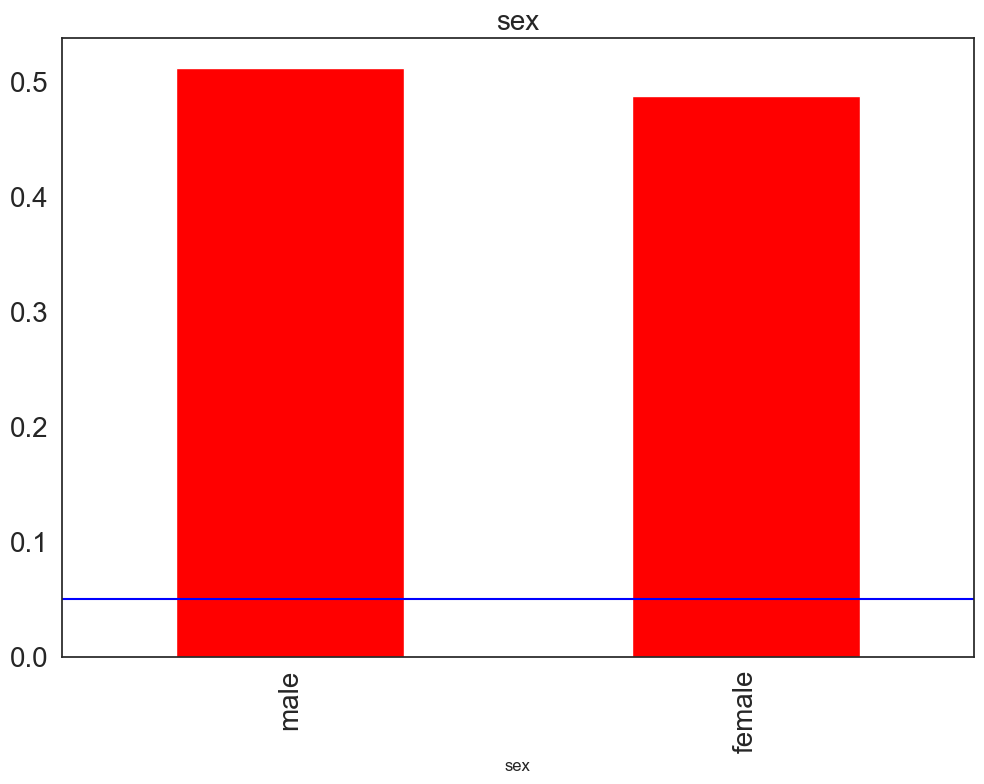

The cardinality of the variable smoker is: 2


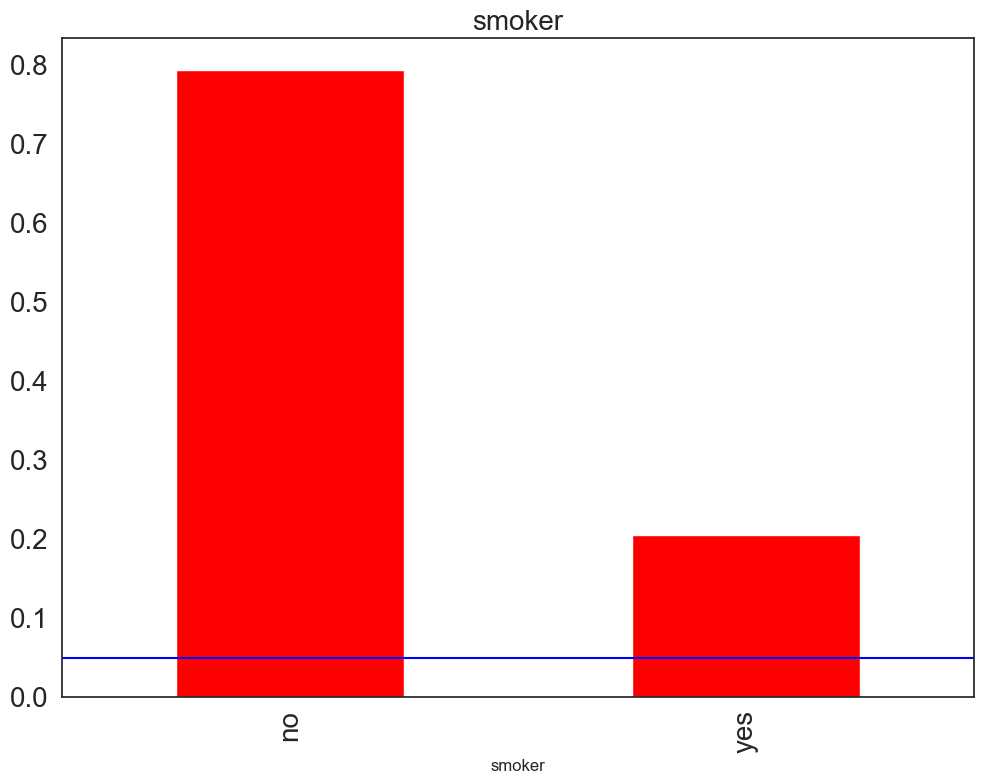

The cardinality of the variable region is: 4


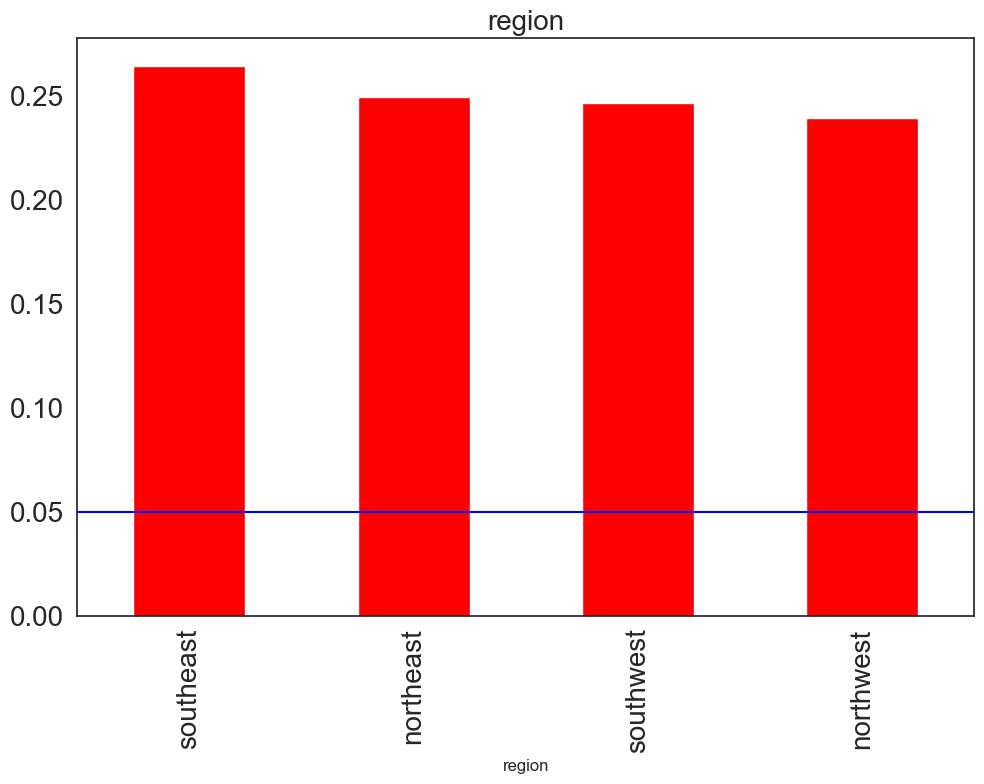

In [12]:
def display_categorical_cardinality(X_train, categorical_variables):
    """plots the cardinality of the categorical variables: number of labels per variable"""
    for variable in categorical_variables:
        print(
            f"The cardinality of the variable {variable} is: {len(X_train[variable].unique())}"
        )

        X_train[variable].value_counts(normalize=True).plot.bar(
            figsize=(10, 8), color="red"
        )
        plt.axhline(y=0.05, color="blue")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.title(variable, fontsize=20)
        plt.tight_layout()

        plt.show()


display_categorical_cardinality(X_train, categorical_var)

## Numerical Variables


In [13]:
# numerical: discrete vs continuous
discrete = [
    var
    for var in X_train.columns
    if X_train[var].dtype != "O" and var != "charges" and X_train[var].nunique() < 10
]

continuous = [
    var
    for var in X_train.columns
    if X_train[var].dtype != "O" and var != "charges" and var not in discrete
]

print(f"There are {len(discrete)} discrete numerical variables which are {discrete}")
print(
    f"There are {len(continuous)} continuous numerical variables which are {continuous}"
)

There are 1 discrete numerical variables which are ['children']
There are 2 continuous numerical variables which are ['age', 'bmi']


In [14]:
# identify numerical columns
numerical_var = X_train.select_dtypes(include=["int64", "float64"]).columns.to_list()
numerical_var

['age', 'bmi', 'children']

In [15]:
X_train[numerical_var].describe()

,age,bmi,children
count,1070.000000,1065.000000,1070.000000
mean,39.357009,30.553840,1.107477
std,14.073960,6.036194,1.215983
min,18.000000,15.960000,0.000000
25%,27.000000,26.220000,0.000000
50%,39.500000,30.210000,1.000000
75%,51.000000,34.485000,2.000000
max,64.000000,53.130000,5.000000


In [16]:
y_train.describe()

count     1070.000000
mean     13346.089736
std      12019.510778
min       1121.873900
25%       4897.667387
50%       9575.442100
75%      16746.657400
max      62592.873090
Name: charges, dtype: float64

In [17]:
def plot_boxplot_and_hist(data, variable):

    # creating a figure composed of two matplotlib.Axes
    # objects (ax_box and ax_hist)

    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)}
    )

    # assigning a graph to each ax
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist, kde=True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel="")
    plt.title(variable)
    plt.show()


def make_qqplot(df, num_col):

    plt.figure(figsize=(10, 6), constrained_layout=True)

    for i, j in enumerate(num_col):
        # location in figure
        ax = plt.subplot(2, 4, i + 1)

        # q-q plot
        stats.probplot((df[j]), dist="norm", plot=plt)

        # add variable name as title
        ax.set_title(j)

    plt.show()

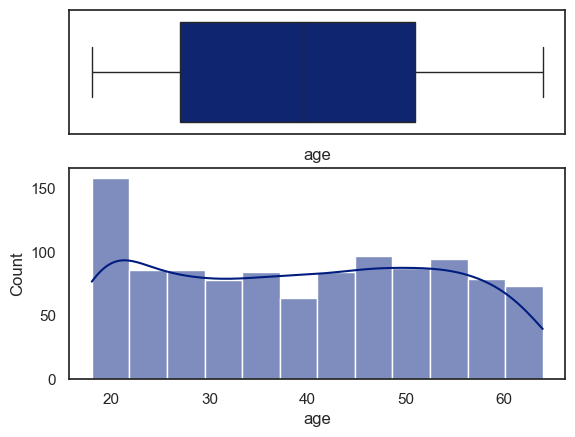

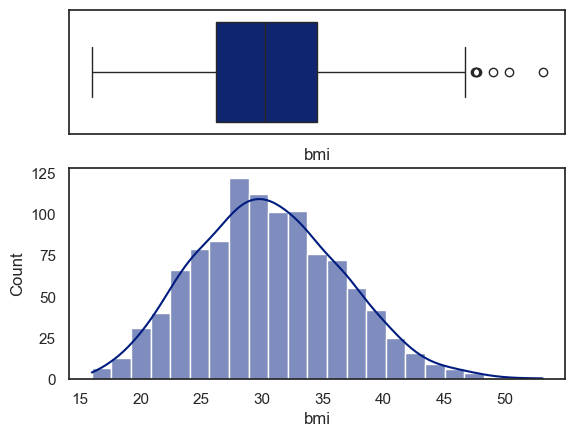

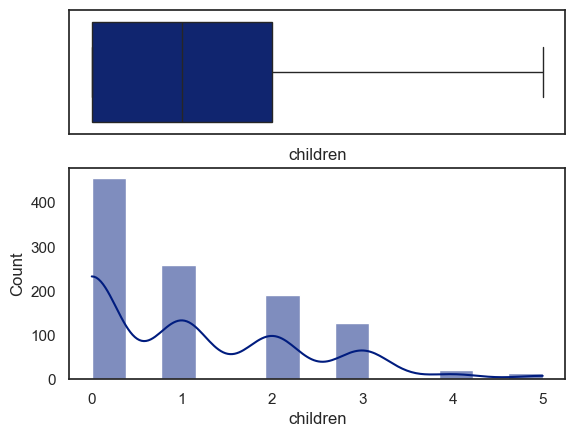

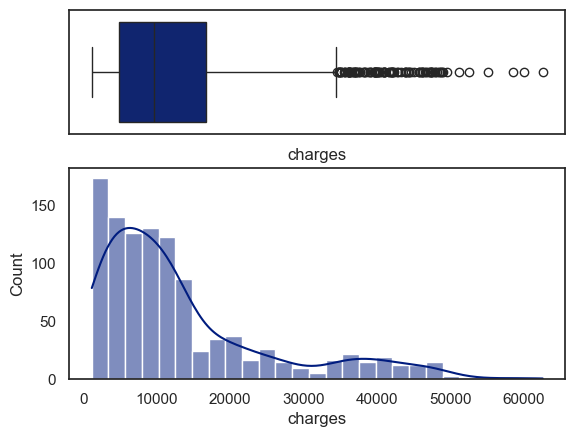

In [18]:
for variable in numerical_var + ["charges"]:
    plot_boxplot_and_hist(X_y, variable)

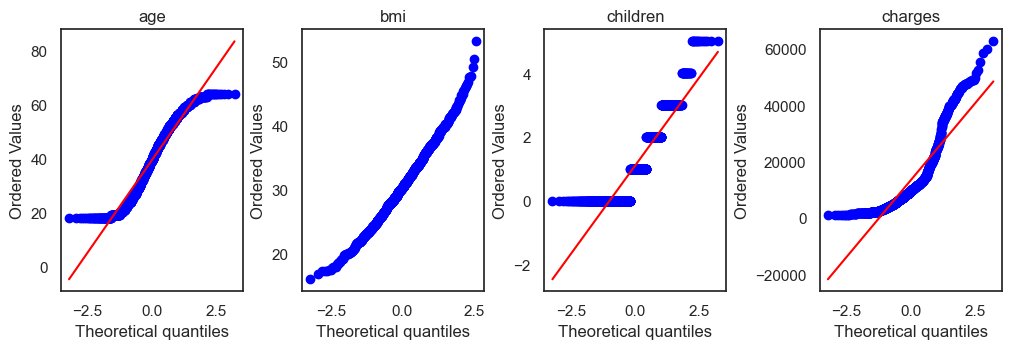

In [19]:
make_qqplot(X_y, numerical_var + ["charges"])

# Data Preprocessing

## Missing data impuation
For this dataset it is unclear how the missing data occur so I am going to assume they happened completely randomly. Median imputation is used as this is robust against outliers and I also used the missing value indicator. 

In [20]:
# check for missing values, there are 5 missing data for the bmi variable
X_train.isnull().mean().sort_values(ascending=False)

bmi         0.004673
age         0.000000
sex         0.000000
children    0.000000
smoker      0.000000
region      0.000000
dtype: float64

In [21]:
features_with_nan = [var for var in X_train.columns if X_train[var].isna().any()]
features_with_nan

['bmi']

In [22]:
imputer = ColumnTransformer(
    [
        (
            "imputer",
            SimpleImputer(strategy="median", add_indicator=True),
            ["bmi"],
        ),
    ],
    remainder="passthrough",
).set_output(transform="pandas")

imputer.fit(X_train)

X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train_imp.head()

,imputer__bmi,imputer__missingindicator_bmi,remainder__age,remainder__sex,remainder__children,remainder__smoker,remainder__region
560,19.95,0.0,46,female,2,no,northwest
1285,24.32,0.0,47,female,0,no,northeast
1142,24.86,0.0,52,female,0,no,southeast
969,34.32,0.0,39,female,5,no,southeast
486,21.47,0.0,54,female,3,no,northwest


In [23]:
X_train_imp.isnull().mean()

imputer__bmi                     0.0
imputer__missingindicator_bmi    0.0
remainder__age                   0.0
remainder__sex                   0.0
remainder__children              0.0
remainder__smoker                0.0
remainder__region                0.0
dtype: float64

In [24]:
tmp = pd.concat([X_train_imp["imputer__bmi"], X_train["bmi"]], axis=1)
tmp.columns = ["imputed", "original"]
tmp.head()

,imputed,original
560,19.95,19.95
1285,24.32,24.32
1142,24.86,24.86
969,34.32,34.32
486,21.47,21.47


<Axes: ylabel='Density'>

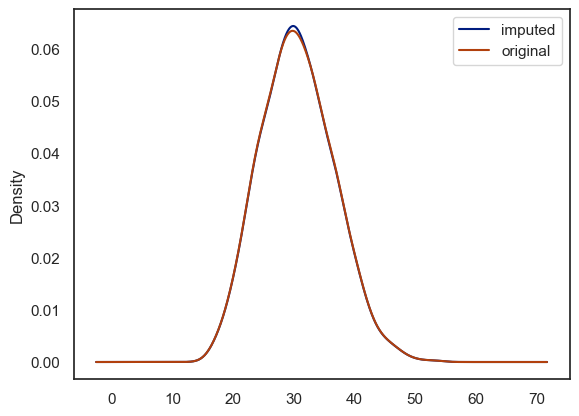

In [25]:
tmp.plot(kind="kde")

The statistical properties remain unchanged as can be seen

In [26]:
categorical_variables_imp = X_train_imp.select_dtypes(
    include=["object"]
).columns.to_list()

categorical_variables_imp

['remainder__sex', 'remainder__smoker', 'remainder__region']

In [27]:
numeric_features_imp = X_train_imp.select_dtypes(
    include=["int64", "float64"]
).columns.to_list()

numeric_features_imp

['imputer__bmi',
 'imputer__missingindicator_bmi',
 'remainder__age',
 'remainder__children']

In [28]:
data_imp = pd.concat([X_train_imp, y_train], axis=1)
# Ensure numerical columns are numeric
data_imp[numeric_features_imp + ["charges"]] = data_imp[
    numeric_features_imp + ["charges"]
].apply(pd.to_numeric, errors="coerce")

data_imp.isnull().mean()

imputer__bmi                     0.0
imputer__missingindicator_bmi    0.0
remainder__age                   0.0
remainder__sex                   0.0
remainder__children              0.0
remainder__smoker                0.0
remainder__region                0.0
charges                          0.0
dtype: float64

In [29]:
# Replace infinite values with NaN and drop rows with NaN values
data_imp = data_imp.replace([np.inf, -np.inf], np.nan).dropna()

# Verify data types
print(data_imp.dtypes)

imputer__bmi                     float64
imputer__missingindicator_bmi    float64
remainder__age                     int64
remainder__sex                    object
remainder__children                int64
remainder__smoker                 object
remainder__region                 object
charges                          float64
dtype: object


## Correlation 
The most correlated feature id the smokers, which means it has the nmost predictive power than all the other input features. This is followed by age, which can also be seen in the pairplots below as well

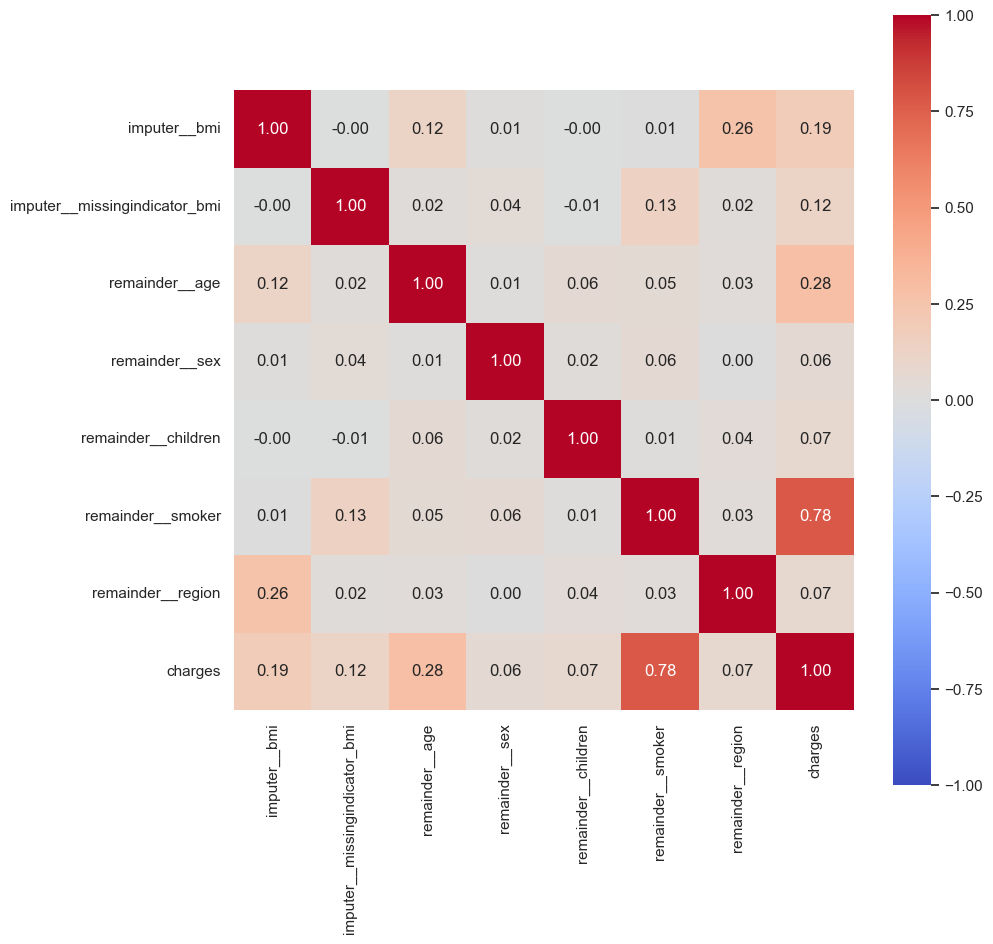

In [30]:
assoc = associations(
    data_imp,
    nominal_columns=categorical_variables_imp,
    numerical_columns=numeric_features_imp + ["charges"],
    nom_nom_assoc="cramer",
    num_num_assoc="pearson",
    nom_num_assoc="correlation_ratio",
    plot=True,
    cmap="coolwarm",
    figsize=(10, 10),
)

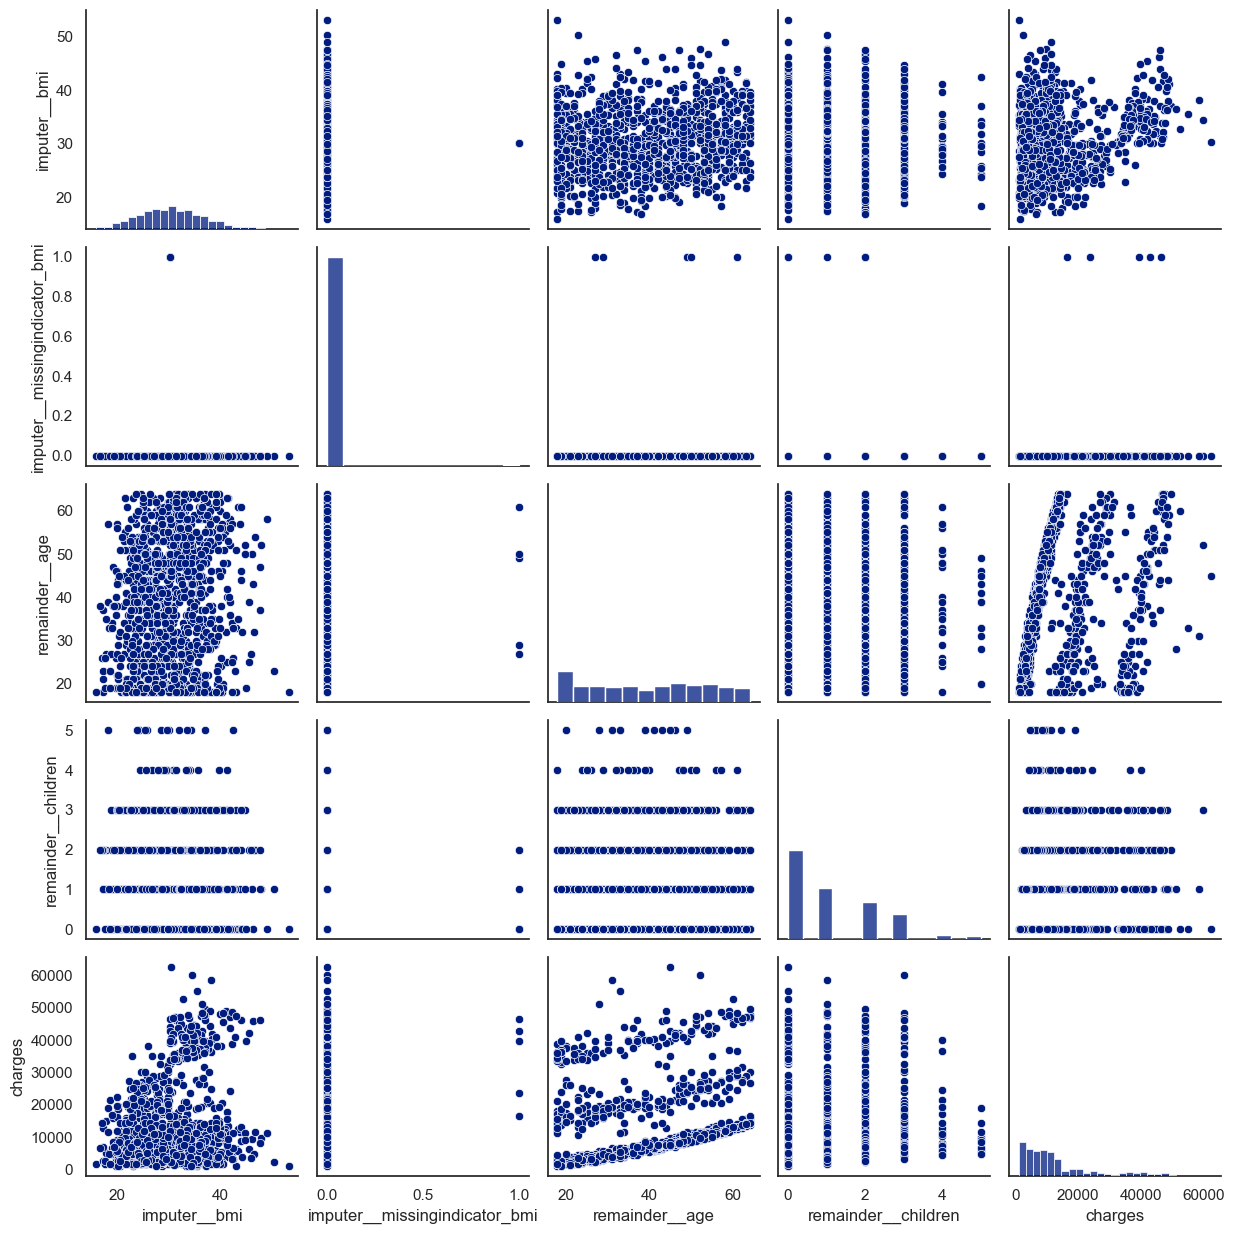

In [31]:
sns.pairplot(data_imp.select_dtypes(include=["int64", "float64"]))
plt.tight_layout()
plt.show()

## Power transformation
This changes the distribution of the data, reducing the variance in the process

In [32]:
# initialize the transformer with yeo-johnson
col_trans = [
    "remainder__age",
    "remainder__children",
    "imputer__bmi",
]
transformer = PowerTransformer(method="yeo-johnson", standardize=False)

transformer.set_output(transform="pandas")
transformer.fit(X_train_imp[col_trans])

X_tf = transformer.transform(X_train_imp[col_trans])

X_tf.head()

,remainder__age,remainder__children,imputer__bmi
560,18.195253,0.909353,6.451049
1285,18.474920,-0.000000,7.215873
1142,19.845512,-0.000000,7.305122
969,16.178971,1.324910,8.726029
486,20.381674,1.094336,6.726326


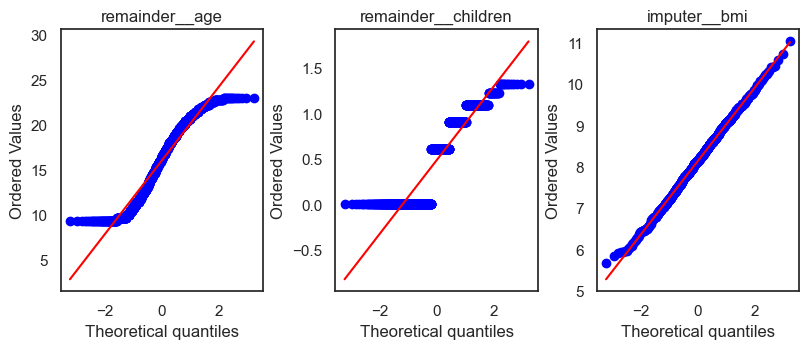

In [33]:
make_qqplot(X_tf, col_trans)

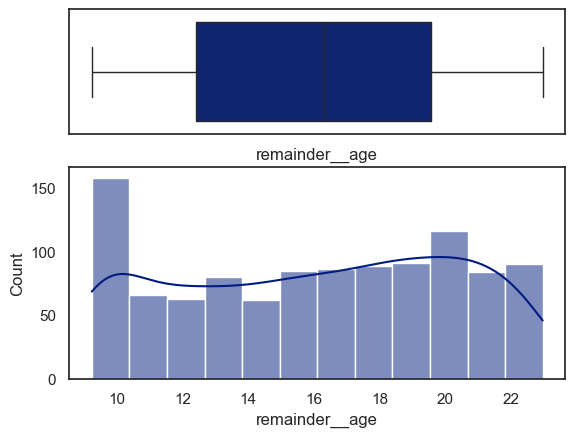

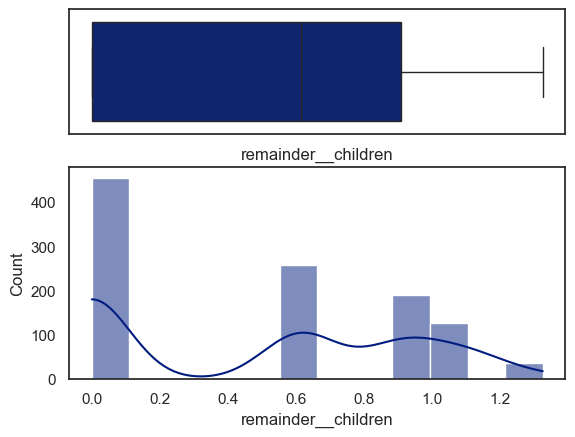

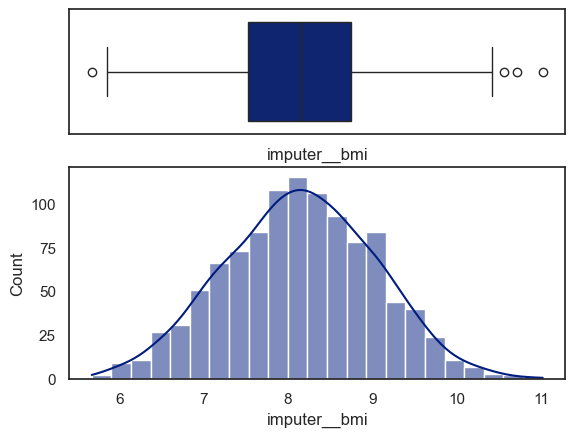

In [34]:
for variable in col_trans:
    plot_boxplot_and_hist(X_tf, variable)

## Outliers (capping)

Detection: using quantile and IQR for a skewed distribution and mean plus std for a normally distributed variable.

Techniques for handling include: trimming (removing outliers), censoring (capping), discretization,

In [35]:
capper = Winsorizer(
    variables=[
        "remainder__age",
        "remainder__children",
        "imputer__bmi",
    ],
    capping_method="quantiles",
    tail="both",
    fold=0.02,
)

capper.fit(X_tf)

Winsorizer(capping_method='quantiles', fold=0.02, tail='both',
           variables=['remainder__age', 'remainder__children', 'imputer__bmi'])

In [36]:
capper.left_tail_caps_

{'remainder__age': 9.239135203818025,
 'remainder__children': 0.0,
 'imputer__bmi': 6.385762727543045}

In [37]:
capper.right_tail_caps_

{'remainder__age': 22.719316931166667,
 'remainder__children': 1.2253340703037925,
 'imputer__bmi': 9.924170142026483}

In [38]:
X_train_imp_enc = capper.transform(X_tf)
X_test_imp_enc = capper.transform(X_tf)

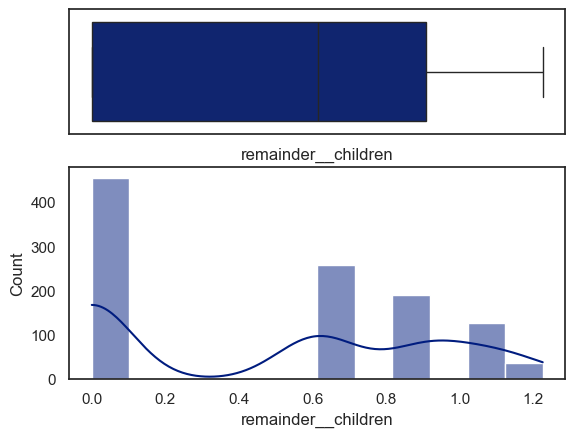

In [39]:
plot_boxplot_and_hist(X_train_imp_enc, "remainder__children")

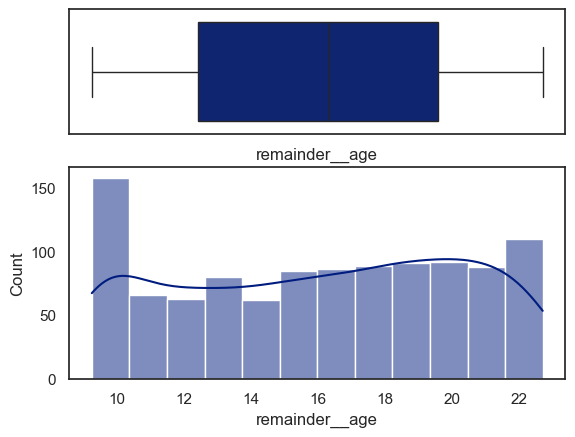

In [40]:
plot_boxplot_and_hist(X_train_imp_enc, "remainder__age")

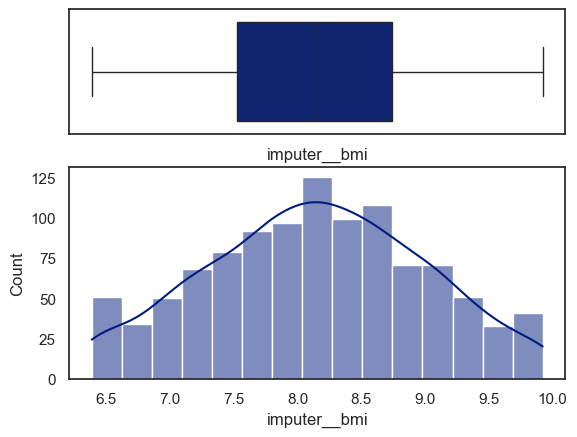

In [41]:
plot_boxplot_and_hist(X_train_imp_enc, "imputer__bmi")

In [42]:
## Discritization

# disc = KBinsDiscretizer(
#     n_bins=10,
#     encode="ordinal",
#     strategy="quantile",
#     subsample=None,
# )

# disc.set_output(transform="pandas")

# disc.fit(X_train_imp_enc[["remainder__age"]])
# train_t = disc.transform(X_train_imp_enc[["remainder__age"]])
# t1 = train_t["remainder__age"].value_counts(normalize=True).sort_index()
# t1.plot.bar()

## Feature Scaling
Here a standard scaler os 

## Encoding categorical variables
The categorical features are one-hot encoded below

## Target variable
Thre response variable is skewed so a log transformation has been applied to normalise the data

<Axes: >

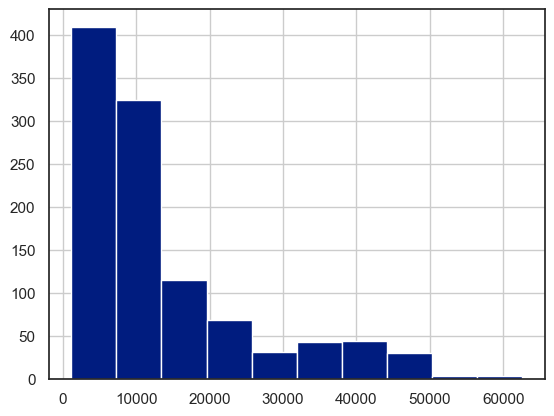

In [43]:
y_train.hist()

<Axes: >

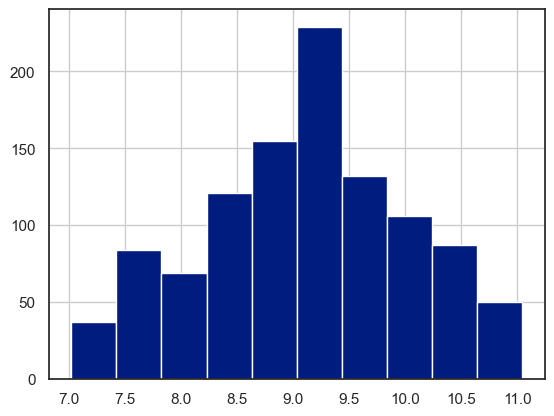

In [44]:
y_train_enc = y_train.copy()
# y_train_enc.hist()
y_train_enc = np.log1p(y_train_enc)
y_train_enc.hist()

<Axes: >

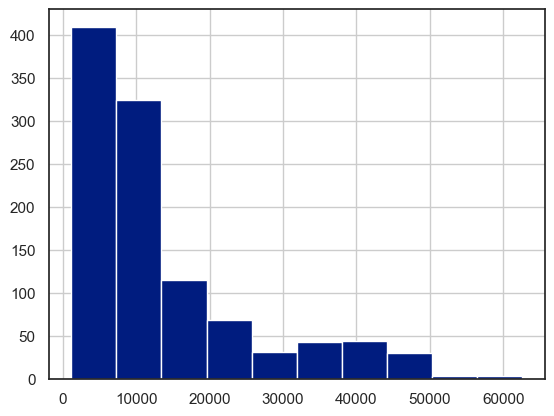

In [45]:
orig_y_train = np.expm1(y_train_enc)
orig_y_train.hist()

## Pipeline

In [46]:
imputer = ColumnTransformer(
    transformers=[
        (
            "step1",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
                    (
                        "power",
                        PowerTransformer(method="yeo-johnson", standardize=False),
                    ),
                    ("scale", StandardScaler()),
                ]
            ),
            ["bmi"],
        ),
        (
            "step2",
            Pipeline(
                [
                    (
                        "power",
                        PowerTransformer(method="yeo-johnson", standardize=False),
                    ),
                    ("scale", StandardScaler()),
                ]
            ),
            ["age", "children"],
        ),
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="error", drop="first"),
            ["sex", "smoker", "region"],
        ),
    ],
    remainder="passthrough",
).set_output(transform="pandas")

capper = Winsorizer(
    variables=[
        "step2__age",
        "step2__children",
        "step1__bmi",
    ],
    capping_method="quantiles",
    tail="both",
    fold=0.02,
)

final_pipeline = Pipeline(
    steps=[
        ("imputer", imputer),
        ("capping", capper),
        # ("capping", capper),  # capping part 3
    ]
)

final_pipeline.fit(X_train)
X_train_imp_num_cat = final_pipeline.transform(X_train)
X_test_imp_num_cat = final_pipeline.transform(X_test)
y_train_enc = np.log1p(y_train)
y_test_enc = np.log1p(y_test)
X_train_imp_num_cat.head()

,step1__bmi,step1__missingindicator_bmi,step2__age,step2__children,encoder__sex_male,encoder__smoker_yes,encoder__region_northwest,encoder__region_southeast,encoder__region_southwest
560,-1.904266,-0.068519,0.512462,0.945687,0.0,0.0,1.0,0.0,0.0
1285,-1.042854,-0.068519,0.578718,-1.079282,0.0,0.0,0.0,0.0,0.0
1142,-0.942335,-0.068519,0.903422,-1.079282,0.0,0.0,0.0,1.0,0.0
969,0.658015,-0.068519,0.034790,1.649321,0.0,0.0,0.0,1.0,0.0
486,-1.594225,-0.068519,1.030443,1.357612,0.0,0.0,1.0,0.0,0.0


In [47]:
X_train_imp_num_cat.shape

(1070, 9)

In [48]:
X_train_imp_num_cat.isnull().mean()

step1__bmi                     0.0
step1__missingindicator_bmi    0.0
step2__age                     0.0
step2__children                0.0
encoder__sex_male              0.0
encoder__smoker_yes            0.0
encoder__region_northwest      0.0
encoder__region_southeast      0.0
encoder__region_southwest      0.0
dtype: float64

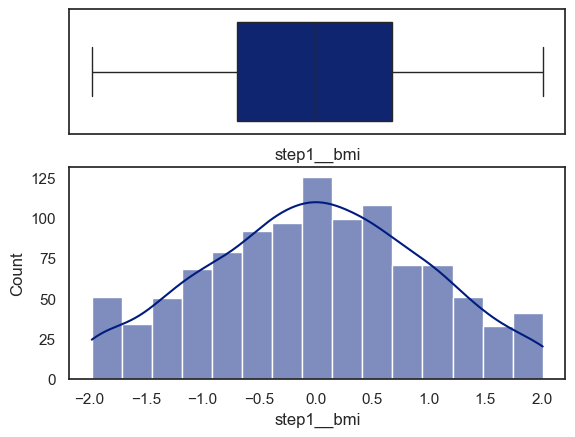

In [49]:
plot_boxplot_and_hist(X_train_imp_num_cat, "step1__bmi")

In [50]:
X_test_imp_num_cat.head()

,step1__bmi,step1__missingindicator_bmi,step2__age,step2__children,encoder__sex_male,encoder__smoker_yes,encoder__region_northwest,encoder__region_southeast,encoder__region_southwest
764,-0.884236,-0.068519,0.445740,0.945687,0.0,0.0,0.0,0.0,0.0
887,-0.035446,-0.068519,-0.178268,-1.079282,0.0,0.0,1.0,0.0,0.0
890,-0.575413,-0.068519,1.584249,-1.079282,0.0,1.0,1.0,0.0,0.0
1293,-0.780083,-0.068519,0.512462,1.357612,1.0,0.0,1.0,0.0,0.0
259,0.277151,-0.068519,-1.520423,-1.079282,1.0,1.0,1.0,0.0,0.0


In [51]:
X_test_imp_num_cat.shape

(268, 9)

## Feature Selection

In [54]:
imputer = ColumnTransformer(
    transformers=[
        (
            "step1",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
                    (
                        "power",
                        PowerTransformer(method="yeo-johnson", standardize=False),
                    ),
                    ("scale", StandardScaler()),
                ]
            ),
            ["bmi"],
        ),
        (
            "step2",
            Pipeline(
                [
                    (
                        "power",
                        PowerTransformer(method="yeo-johnson", standardize=False),
                    ),
                    ("scale", StandardScaler()),
                ]
            ),
            ["age", "children"],
        ),
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="error", drop="first"),
            ["sex", "smoker", "region"],
        ),
    ],
    remainder="passthrough",
).set_output(transform="pandas")

capper = Winsorizer(
    variables=[
        "step2__age",
        "step2__children",
        "step1__bmi",
    ],
    capping_method="quantiles",
    tail="both",
    fold=0.02,
)


pipe_sel = Pipeline(
    [
        ("constant", DropConstantFeatures(tol=0.998)),
        ("duplicated", DropDuplicateFeatures()),
        (
            "cor",
            SmartCorrelatedSelection(
                selection_method="variance",
                variables=None,  # if none, selector examines all numerical variables
                method="pearson",
                threshold=0.2,
                scoring="r2",
                cv=5,
                missing_values="raise",
            ),
        ),
    ]
)

final_pipeline = Pipeline(
    steps=[
        ("imputer", imputer),
        ("capping", capper),
        ("selection", pipe_sel),  # capping part 3
    ]
)

final_pipeline.fit(X_train)
X_train_imp_num_cat = final_pipeline.transform(X_train)
X_test_imp_num_cat = final_pipeline.transform(X_test)
y_train_enc = np.log1p(y_train)
y_test_enc = np.log1p(y_test)
X_train_imp_num_cat.head()

,step1__bmi,step1__missingindicator_bmi,step2__age,step2__children,encoder__sex_male,encoder__smoker_yes,encoder__region_southwest
560,-1.904266,-0.068519,0.512462,0.945687,0.0,0.0,0.0
1285,-1.042854,-0.068519,0.578718,-1.079282,0.0,0.0,0.0
1142,-0.942335,-0.068519,0.903422,-1.079282,0.0,0.0,0.0
969,0.658015,-0.068519,0.034790,1.649321,0.0,0.0,0.0
486,-1.594225,-0.068519,1.030443,1.357612,0.0,0.0,0.0


In [55]:
X_train_imp_num_cat.shape

(1070, 7)

In [57]:
X_test_imp_num_cat.head()

,step1__bmi,step1__missingindicator_bmi,step2__age,step2__children,encoder__sex_male,encoder__smoker_yes,encoder__region_southwest
764,-0.884236,-0.068519,0.445740,0.945687,0.0,0.0,0.0
887,-0.035446,-0.068519,-0.178268,-1.079282,0.0,0.0,0.0
890,-0.575413,-0.068519,1.584249,-1.079282,0.0,1.0,0.0
1293,-0.780083,-0.068519,0.512462,1.357612,1.0,0.0,0.0
259,0.277151,-0.068519,-1.520423,-1.079282,1.0,1.0,0.0


# Modeling: Model Selection Using KFold Cross-Validation

In [56]:
# Function to calculate adjusted R2
def adjusted_r2_score(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


# Function to evaluate models with cross-validation, including adjusted R2
def evaluate_model_cv(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(
        model,
        X,
        y,
        scoring=make_scorer(root_mean_squared_error),
        cv=kf,
        error_score="raise",
    )
    r2_scores = cross_val_score(
        model, X, y, scoring=make_scorer(r2_score), cv=kf, error_score="raise"
    )
    adjusted_r2_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        n = len(y_test)
        k = X.shape[1]
        adjusted_r2_scores.append(adjusted_r2_score(r2, n, k))

    return (
        np.mean(mse_scores),
        np.mean(r2_scores),
        np.mean(adjusted_r2_scores),
    )

In [58]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "LARS": Lars(eps=1e-3),
    "LassoLARS": LassoLars(),
    "OMP": OrthogonalMatchingPursuit(),
    "BayesianRidge": BayesianRidge(),
    "ARD": ARDRegression(),
    "SGD": SGDRegressor(),
    "PassiveAggressive": PassiveAggressiveRegressor(),
    "Huber": HuberRegressor(),
    "Quantile": QuantileRegressor(solver="highs"),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "LinearSVR": LinearSVR(dual="auto", max_iter=10000),
    "KNeighbors Regressor": KNeighborsRegressor(),
    # "RadiusNeighbors Regressor": RadiusNeighborsRegressor(radius=1.0),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Extra Trees Regressor": ExtraTreesRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor(),
    "Bagging Regressor": BaggingRegressor(),
    "Voting Regressor": VotingRegressor(
        estimators=[
            ("dt", DecisionTreeRegressor()),
            ("rf", RandomForestRegressor()),
            ("et", ExtraTreesRegressor()),
        ]
    ),
    "Stacking Regressor": StackingRegressor(
        estimators=[
            ("dt", DecisionTreeRegressor()),
            ("rf", RandomForestRegressor()),
            ("et", ExtraTreesRegressor()),
        ]
    ),
    "XGBoost Regressor": XGBRegressor(),
    # "Gaussian Process Regressor": GaussianProcessRegressor(),
    # "Gaussian Naive Bayes": GaussianNB(),
    # "Multinomial Naive Bayes": MultinomialNB(),
    # "Bernoulli Naive Bayes": BernoulliNB(),
    # "Complement Naive Bayes": ComplementNB(),
    # "Categorical Naive Bayes": CategoricalNB(),
    # "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    # "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "MLP Regressor": MLPRegressor(max_iter=10000),
}

results = {}
results_ = {}
results__ = {}

for name, model in models.items():
    mse, r2, ar2 = evaluate_model_cv(
        model,
        X_train_imp_num_cat,
        y_train_enc,
    )
    # scores = cross_val_score(
    #     model,
    #     X_train_imp_num_cat,
    #     y_train_enc,
    #     cv=5,
    #     scoring="r2",
    # )
    results[name] = r2
    results_[name] = mse
    results__[name] = ar2

    print(
        f"{name}: Mean r2 = {r2:.4f}, Mean adjusted r2 = {ar2:.4f},  Mean rmse = {mse:.4f}"
    )

# Comparing models
best_model = max(results, key=results.get)
best_model_ = min(results_, key=results_.get)
best_model__ = max(results_, key=results__.get)

print(f"Best model based on r2: {best_model} with an r2 of {results[best_model]:.4f}")
print(
    f"Best model based on rmse: {best_model_} with an rmse of {results_[best_model_]:.4f}"
)
print(
    f"Best model based on adjusted r2: {best_model__} with an adjusted r2 of {results__[best_model__]:.4f}"
)

Linear Regression: Mean r2 = 0.7522, Mean adjusted r2 = 0.7438,  Mean rmse = 0.4519
Ridge: Mean r2 = 0.7522, Mean adjusted r2 = 0.7438,  Mean rmse = 0.4519
Lasso: Mean r2 = -0.0062, Mean adjusted r2 = -0.0404,  Mean rmse = 0.9119
ElasticNet: Mean r2 = -0.0062, Mean adjusted r2 = -0.0404,  Mean rmse = 0.9119
LARS: Mean r2 = 0.7522, Mean adjusted r2 = 0.7438,  Mean rmse = 0.4519
LassoLARS: Mean r2 = -0.0062, Mean adjusted r2 = -0.0404,  Mean rmse = 0.9119
OMP: Mean r2 = 0.2597, Mean adjusted r2 = 0.2345,  Mean rmse = 0.7820
BayesianRidge: Mean r2 = 0.7522, Mean adjusted r2 = 0.7438,  Mean rmse = 0.4519
ARD: Mean r2 = 0.7522, Mean adjusted r2 = 0.7437,  Mean rmse = 0.4520
SGD: Mean r2 = 0.7486, Mean adjusted r2 = 0.7404,  Mean rmse = 0.4552
PassiveAggressive: Mean r2 = 0.1023, Mean adjusted r2 = 0.2423,  Mean rmse = 0.9311
Huber: Mean r2 = 0.7303, Mean adjusted r2 = 0.7211,  Mean rmse = 0.4711
Quantile: Mean r2 = -0.0100, Mean adjusted r2 = -0.0443,  Mean rmse = 0.9136
SVR: Mean r2 = 0.81

# Hyperparameter Optimization
This improved the performance by 4% and the generalization metric or r2 score is 86% which means the model can explain 86% variance in the data

In [59]:
# Define the objective function
def objective(params):
    # Create the model with given hyperparameters
    model = SVR(**params)

    # Evaluate the model using cross-validation
    scores = cross_val_score(
        model, X_train_imp_num_cat, y_train_enc, cv=5, scoring="neg_mean_squared_error"
    )

    # Since Hyperopt minimizes the objective function, we need to return the negative of mean MSE
    mean_mse = -np.mean(scores)
    return {"loss": mean_mse, "status": STATUS_OK}


# Define the hyperparameter search space
space = {
    "C": hp.loguniform("C", np.log(0.01), np.log(100)),
    "epsilon": hp.loguniform("epsilon", np.log(0.01), np.log(1)),
    "kernel": hp.choice("kernel", ["linear", "poly", "rbf", "sigmoid"]),
    "degree": scope.int(hp.quniform("degree", 2, 5, 1)),  # for poly kernel
    "gamma": hp.choice("gamma", ["scale", "auto"]),
    "coef0": hp.uniform("coef0", 0, 1),  # for poly and sigmoid kernels
}

# Create a Trials object to store the results of each iteration
trials = Trials()

# Run the optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# print("Best parameters found:", best)

# Train the final model with the best parameters
best_params = {
    "C": best["C"],
    "epsilon": best["epsilon"],
    "kernel": ["linear", "poly", "rbf", "sigmoid"][best["kernel"]],
    "degree": int(best["degree"]),
    "gamma": ["scale", "auto"][best["gamma"]],
    "coef0": best["coef0"],
}

# final_model = SVR(**best_params)
# final_model.fit(X_train_imp_num_cat, y_train_enc)
print(f"best hyperparameters are: {best_params}")

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [01:03<00:00,  1.57trial/s, best loss: 0.14675521062044244]
best hyperparameters are: {'C': 0.12672351318044592, 'epsilon': 0.13213519684655817, 'kernel': 'poly', 'degree': 4, 'gamma': 'auto', 'coef0': 0.9589562620566648}


In [60]:
def run_model(X_train, X_test, y_train, y_test, params):

    model = SVR(**params)
    model.fit(X_train, y_train)

    print("Train set")
    pred = model.predict(X_train)
    print("XGBoost AUPRC: {}".format(r2_score(y_train, pred)))

    print("Test set")
    pred = model.predict(X_test)
    print("XGBoost AUPRC: {}".format(r2_score(y_test, pred)))

    return model, pred


model, pred = run_model(
    X_train_imp_num_cat, X_test_imp_num_cat, y_train_enc, y_test_enc, best_params
)

Train set
XGBoost AUPRC: 0.8288989356354171
Test set
XGBoost AUPRC: 0.8606199308155905


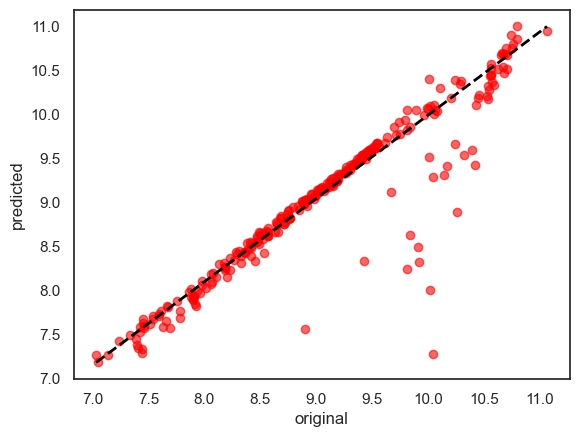

In [61]:
plt.figure()
plt.scatter(y_test_enc, pred, color="red", alpha=0.6)
plt.plot([y_test_enc.min(), y_test_enc.max()], [pred.min(), pred.max()], "k--", lw=2)

plt.xlabel("original")
plt.ylabel("predicted")
plt.show()

# AI Explainability

### Global Explainability with SHAP

In [62]:
explainer = shap.Explainer(model.predict, X_train_imp_num_cat)
shape_values = explainer(X_test_imp_num_cat)

ExactExplainer explainer: 269it [00:12,  5.58it/s]                         


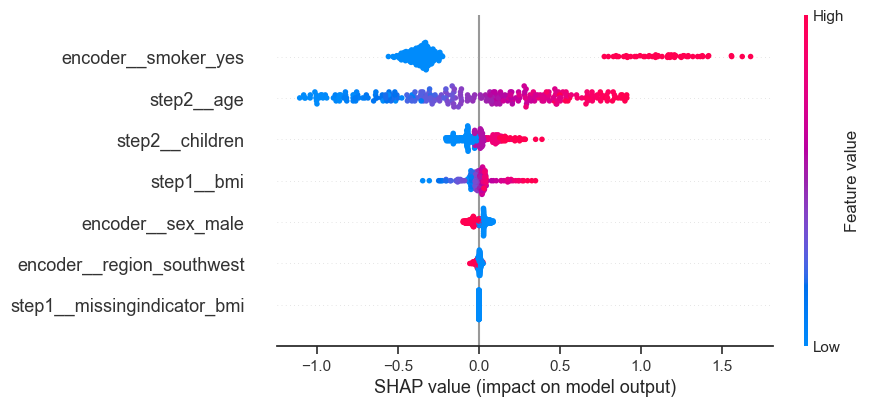

In [63]:
shap.plots.beeswarm(shape_values, max_display=14)

### Global Explainability with Permutation Feature Importance

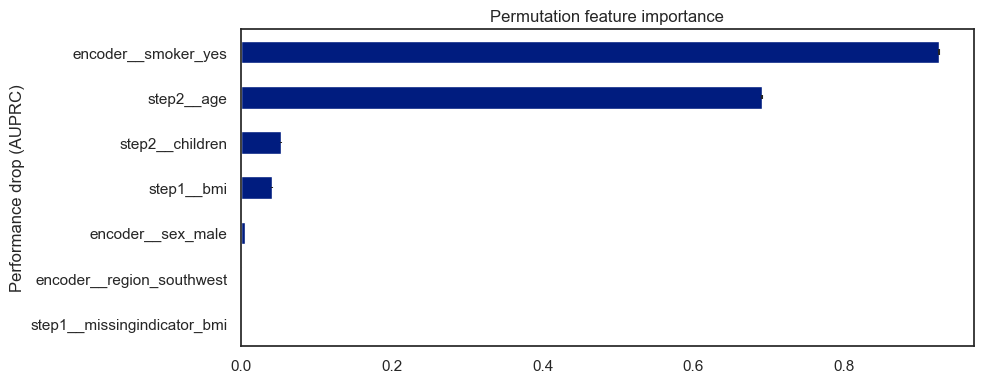

In [68]:
r = permutation_importance(
    model,
    X_test_imp_num_cat,  # we use the test set
    y_test_enc,
    scoring=make_scorer(r2_score),  # we can use any metric
    n_repeats=5,
    random_state=0,
)

importance = pd.DataFrame(
    {"importance_mean": r["importances_mean"], "importance_std": r["importances_std"]},
    index=final_pipeline.get_feature_names_out(),
)
# The larger the drop, the more important the feature

importance["importance_mean"].sort_values(ascending=False).plot(
    figsize=(10, 4), kind="barh", yerr=importance["importance_std"]
)

plt.title("Permutation feature importance")
plt.ylabel("Performance drop (AUPRC)")
plt.gca().invert_yaxis()  # Invert the Y-axis to show the most important feature at the top
plt.tight_layout()
plt.show()